# ANALYSIS FOR TEXTUALVERIFIER ONLY

- Comparative analysis for 5 different number variants of TextualVerifier
- Author: Eugenius Mario Situmorang
- Date: June 2025

In [23]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import json
import re
from scipy import stats
from scipy.stats import fisher_exact
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

## DATA LOADING AND PREPROCESSING FOR MULTIPLE VERSIONS

In [24]:
def load_multiple_versions():
    """
    Load all 5 versions of verification data
    """
    print("🔄 Loading multiple versions...")
    
    # Define file paths and version names
    version_files = {
        "Version 1": "results/textualverifier-1v.csv",
        "Version 2": "results/textualverifier-2v.csv", 
        "Version 3": "results/textualverifier-3v.csv",
        "Version 4": "results/textualverifier-4v.csv",
        "Version 5": "results/textualverifier-5v.csv"
    }
    
    dataframes = {}
    
    for version_name, file_path in version_files.items():
        try:
            df = pd.read_csv(file_path)
            
            # Add version identifier
            df['version'] = version_name
            
            # Basic preprocessing
            df['success'] = df['success'].astype(bool) if 'success' in df.columns else True
            
            # Handle answer correctness columns
            if 'original_answer_correctness' in df.columns:
                df['original_answer_correctness'] = df['original_answer_correctness'].str.strip().str.upper() == 'TRUE'
            if 'verifier_answer_correctness' in df.columns:
                df['verifier_answer_correctness'] = df['verifier_answer_correctness'].str.strip().str.upper() == 'TRUE'
            
            # Parse rating arrays
            def parse_rating_array(rating_str):
                try:
                    if pd.isna(rating_str):
                        return []
                    rating_str = str(rating_str).strip('[]')
                    return [int(x.strip()) for x in rating_str.split(',') if x.strip()]
                except:
                    return []
            
            if 'original_rating' in df.columns:
                df['original_rating_parsed'] = df['original_rating'].apply(parse_rating_array)
                df['original_avg_rating'] = df['original_rating_parsed'].apply(lambda x: np.mean(x) if x else np.nan)
            
            if 'verified_rating' in df.columns:
                df['verified_rating_parsed'] = df['verified_rating'].apply(parse_rating_array)
                df['verified_avg_rating'] = df['verified_rating_parsed'].apply(lambda x: np.mean(x) if x else np.nan)
            
            # Calculate derived metrics
            if 'original_avg_rating' in df.columns and 'verified_avg_rating' in df.columns:
                df['rating_improvement'] = df['verified_avg_rating'] - df['original_avg_rating']
            
            if 'verified_total_steps' in df.columns and 'original_total_steps' in df.columns:
                df['step_change'] = df['verified_total_steps'] - df['original_total_steps']
            
            if 'total_output_tokens' in df.columns and 'total_input_tokens' in df.columns:
                df['token_efficiency'] = df['total_output_tokens'] / (df['total_input_tokens'] + 1)
            
            dataframes[version_name] = df
            print(f"✅ {version_name}: {len(df)} records loaded")
            
        except Exception as e:
            print(f"❌ Error loading {version_name}: {e}")
            continue
    
    # Combine all dataframes
    if dataframes:
        combined_df = pd.concat(dataframes.values(), ignore_index=True)
        print(f"\n🎯 Total combined dataset: {len(combined_df)} records across {len(dataframes)} versions")
        return combined_df, dataframes
    else:
        print("❌ No data loaded successfully")
        return None, {}

# Load all versions
combined_df, version_dfs = load_multiple_versions()

🔄 Loading multiple versions...
✅ Version 1: 70 records loaded
✅ Version 2: 70 records loaded
✅ Version 3: 70 records loaded
✅ Version 4: 70 records loaded
✅ Version 5: 70 records loaded

🎯 Total combined dataset: 350 records across 5 versions


## MULTI-VERSION COMPARATIVE ANALYSIS

In [25]:
def comparative_foundational_analysis(combined_df):
    """
    Compare foundational metrics across all versions
    """
    print("\n" + "="*70)
    print("📈 COMPARATIVE FOUNDATIONAL ANALYSIS")
    print("="*70)
    
    results = {}
    
    # Group by version for analysis
    version_stats = combined_df.groupby('version').agg({
        'success': ['count', 'mean'],
        'original_answer_correctness': 'mean',
        'verifier_answer_correctness': 'mean', 
        'processing_time_ms': ['mean', 'median', 'std'],
        'total_llm_calls': ['mean', 'median'],
        'total_input_tokens': 'mean',
        'total_output_tokens': 'mean',
        'token_efficiency': ['mean', 'std']
    }).round(3)
    
    # Flatten column names
    version_stats.columns = ['_'.join(col).strip() for col in version_stats.columns]
    
    # Calculate accuracy improvements
    accuracy_improvements = {}
    for version in combined_df['version'].unique():
        version_data = combined_df[combined_df['version'] == version]
        original_acc = version_data['original_answer_correctness'].mean() * 100
        verified_acc = version_data['verifier_answer_correctness'].mean() * 100
        accuracy_improvements[version] = verified_acc - original_acc
    
    results['version_stats'] = version_stats
    results['accuracy_improvements'] = accuracy_improvements
    
    # Print comparison summary
    print("📊 VERSION COMPARISON SUMMARY:")
    print("-" * 50)
    
    for version in combined_df['version'].unique():
        version_data = combined_df[combined_df['version'] == version]
        success_rate = version_data['success'].mean() * 100
        accuracy_improvement = accuracy_improvements[version]
        avg_time = version_data['processing_time_ms'].mean()
        avg_llm_calls = version_data['total_llm_calls'].mean()
        
        print(f"\n{version}:")
        print(f"  • Success Rate: {success_rate:.1f}%")
        print(f"  • Accuracy Improvement: {accuracy_improvement:+.1f} pp")
        print(f"  • Avg Processing Time: {avg_time:.1f} ms")
        print(f"  • Avg LLM Calls: {avg_llm_calls:.1f}")
    
    # Statistical significance tests
    print(f"\n🔬 STATISTICAL SIGNIFICANCE TESTS:")
    print("-" * 40)
    
    versions = list(combined_df['version'].unique())
    
    # Compare success rates using Fisher's exact test (more robust than chi-square)
    if len(versions) >= 2:
        for i in range(len(versions)):
            for j in range(i+1, len(versions)):
                v1_success = combined_df[combined_df['version'] == versions[i]]['success']
                v2_success = combined_df[combined_df['version'] == versions[j]]['success']
                
                if len(v1_success) > 0 and len(v2_success) > 0:
                    try:
                        # Create contingency table
                        v1_successes = v1_success.sum()
                        v1_failures = len(v1_success) - v1_successes
                        v2_successes = v2_success.sum()
                        v2_failures = len(v2_success) - v2_successes
                        
                        contingency_table = [[v1_successes, v1_failures], 
                                           [v2_successes, v2_failures]]
                        
                        # Use Fisher's exact test for small samples or when chi-square assumptions violated
                        if any(cell < 5 for row in contingency_table for cell in row):
                            odds_ratio, p_value = fisher_exact(contingency_table)
                            test_used = "Fisher's exact"
                        else:
                            # Check if any expected frequencies are zero
                            total = sum(sum(row) for row in contingency_table)
                            row_totals = [sum(row) for row in contingency_table]
                            col_totals = [sum(contingency_table[i][j] for i in range(2)) for j in range(2)]
                            
                            expected_freq_valid = all(
                                (row_totals[i] * col_totals[j]) / total >= 1
                                for i in range(2) for j in range(2)
                            )
                            
                            if expected_freq_valid:
                                stat, p_value = stats.chi2_contingency(contingency_table)[:2]
                                test_used = "Chi-square"
                            else:
                                odds_ratio, p_value = fisher_exact(contingency_table)
                                test_used = "Fisher's exact"
                        
                        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
                        print(f"  Success Rate {versions[i]} vs {versions[j]}: p={p_value:.4f} {significance} ({test_used})")
                        
                    except Exception as e:
                        # Fallback to simple proportion comparison
                        v1_rate = v1_success.mean()
                        v2_rate = v2_success.mean()
                        rate_diff = abs(v1_rate - v2_rate)
                        print(f"  Success Rate {versions[i]} vs {versions[j]}: Rate diff={rate_diff:.3f} (comparison failed: {str(e)[:50]}...)")
    
    return results

# Run comparative foundational analysis
comp_results_1 = comparative_foundational_analysis(combined_df)


📈 COMPARATIVE FOUNDATIONAL ANALYSIS
📊 VERSION COMPARISON SUMMARY:
--------------------------------------------------

Version 1:
  • Success Rate: 100.0%
  • Accuracy Improvement: +1.4 pp
  • Avg Processing Time: 66464.9 ms
  • Avg LLM Calls: 18.8

Version 2:
  • Success Rate: 100.0%
  • Accuracy Improvement: +1.4 pp
  • Avg Processing Time: 196097.7 ms
  • Avg LLM Calls: 56.4

Version 3:
  • Success Rate: 100.0%
  • Accuracy Improvement: +2.9 pp
  • Avg Processing Time: 227156.2 ms
  • Avg LLM Calls: 75.1

Version 4:
  • Success Rate: 100.0%
  • Accuracy Improvement: +5.7 pp
  • Avg Processing Time: 253619.8 ms
  • Avg LLM Calls: 93.9

Version 5:
  • Success Rate: 100.0%
  • Accuracy Improvement: +0.0 pp
  • Avg Processing Time: 327053.2 ms
  • Avg LLM Calls: 112.7

🔬 STATISTICAL SIGNIFICANCE TESTS:
----------------------------------------
  Success Rate Version 1 vs Version 2: p=1.0000 ns (Fisher's exact)
  Success Rate Version 1 vs Version 3: p=1.0000 ns (Fisher's exact)
  Success 

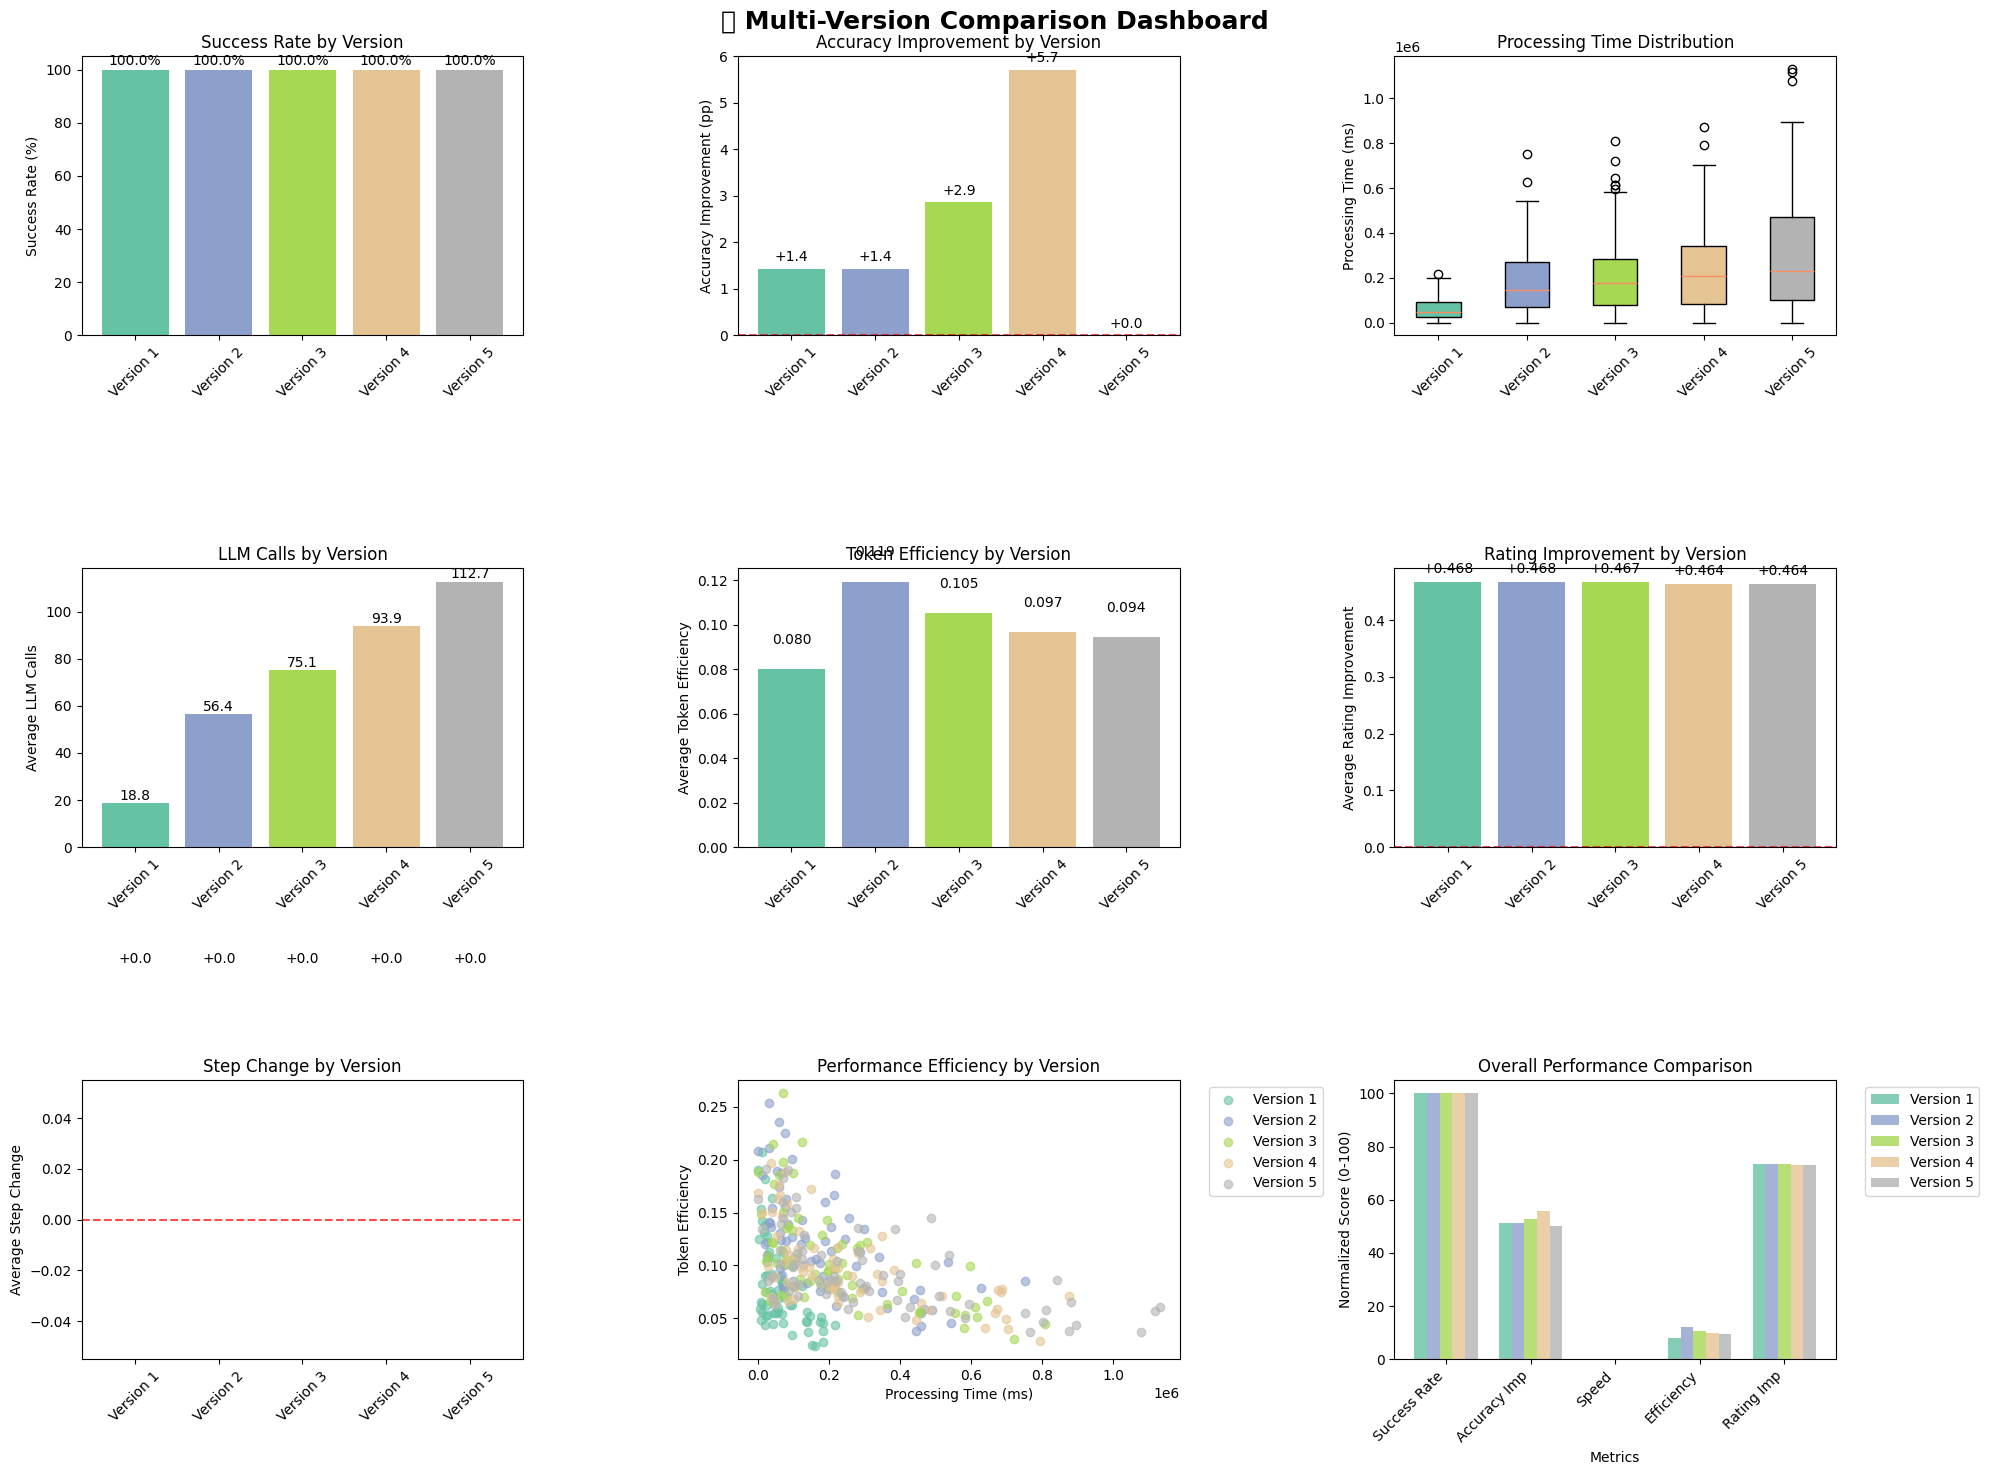

In [26]:
# Visualization for Multi-Version Comparison
def visualize_version_comparison(combined_df):
    """
    Create comprehensive visualizations comparing all versions
    """
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('🔍 Multi-Version Comparison Dashboard', fontsize=18, fontweight='bold')
    
    versions = combined_df['version'].unique()
    colors = plt.cm.Set2(np.linspace(0, 1, len(versions)))
    
    # 1. Success Rate Comparison
    success_rates = []
    for version in versions:
        version_data = combined_df[combined_df['version'] == version]
        success_rates.append(version_data['success'].mean() * 100)
    
    bars1 = axes[0,0].bar(versions, success_rates, color=colors)
    axes[0,0].set_ylabel('Success Rate (%)')
    axes[0,0].set_title('Success Rate by Version')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    for bar, value in zip(bars1, success_rates):
        axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                      f'{value:.1f}%', ha='center', va='bottom')
    
    # 2. Accuracy Improvement Comparison  
    accuracy_improvements = []
    for version in versions:
        version_data = combined_df[combined_df['version'] == version]
        original_acc = version_data['original_answer_correctness'].mean() * 100
        verified_acc = version_data['verifier_answer_correctness'].mean() * 100
        accuracy_improvements.append(verified_acc - original_acc)
    
    bars2 = axes[0,1].bar(versions, accuracy_improvements, color=colors)
    axes[0,1].set_ylabel('Accuracy Improvement (pp)')
    axes[0,1].set_title('Accuracy Improvement by Version')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
    
    for bar, value in zip(bars2, accuracy_improvements):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.1 if value >= 0 else -0.3), 
                      f'{value:+.1f}', ha='center', va='bottom' if value >= 0 else 'top')
    
    # 3. Processing Time Distribution
    processing_times_by_version = []
    labels = []
    for version in versions:
        version_data = combined_df[combined_df['version'] == version]
        times = version_data['processing_time_ms'].dropna()
        if len(times) > 0:
            processing_times_by_version.append(times)
            labels.append(version)
    
    if processing_times_by_version:
        bp1 = axes[0,2].boxplot(processing_times_by_version, labels=labels, patch_artist=True)
        for patch, color in zip(bp1['boxes'], colors):
            patch.set_facecolor(color)
    axes[0,2].set_ylabel('Processing Time (ms)')
    axes[0,2].set_title('Processing Time Distribution')
    axes[0,2].tick_params(axis='x', rotation=45)
    
    # 4. LLM Calls Comparison
    llm_calls_avg = []
    for version in versions:
        version_data = combined_df[combined_df['version'] == version]
        llm_calls_avg.append(version_data['total_llm_calls'].mean())
    
    bars3 = axes[1,0].bar(versions, llm_calls_avg, color=colors)
    axes[1,0].set_ylabel('Average LLM Calls')
    axes[1,0].set_title('LLM Calls by Version')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    for bar, value in zip(bars3, llm_calls_avg):
        axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                      f'{value:.1f}', ha='center', va='bottom')
    
    # 5. Token Efficiency Comparison
    token_efficiency_avg = []
    for version in versions:
        version_data = combined_df[combined_df['version'] == version]
        token_efficiency_avg.append(version_data['token_efficiency'].mean())
    
    bars4 = axes[1,1].bar(versions, token_efficiency_avg, color=colors)
    axes[1,1].set_ylabel('Average Token Efficiency')
    axes[1,1].set_title('Token Efficiency by Version')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    for bar, value in zip(bars4, token_efficiency_avg):
        axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                      f'{value:.3f}', ha='center', va='bottom')
    
    # 6. Rating Improvement Comparison
    rating_improvements = []
    for version in versions:
        version_data = combined_df[combined_df['version'] == version]
        rating_imp = version_data['rating_improvement'].dropna().mean()
        rating_improvements.append(rating_imp if not pd.isna(rating_imp) else 0)
    
    bars5 = axes[1,2].bar(versions, rating_improvements, color=colors)
    axes[1,2].set_ylabel('Average Rating Improvement')
    axes[1,2].set_title('Rating Improvement by Version')
    axes[1,2].tick_params(axis='x', rotation=45)
    axes[1,2].axhline(y=0, color='red', linestyle='--', alpha=0.7)
    
    for bar, value in zip(bars5, rating_improvements):
        axes[1,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.01 if value >= 0 else -0.02), 
                      f'{value:+.3f}', ha='center', va='bottom' if value >= 0 else 'top')
    
    # 7. Step Change Comparison
    step_changes = []
    for version in versions:
        version_data = combined_df[combined_df['version'] == version]
        step_change = version_data['step_change'].dropna().mean()
        step_changes.append(step_change if not pd.isna(step_change) else 0)
    
    bars6 = axes[2,0].bar(versions, step_changes, color=colors)
    axes[2,0].set_ylabel('Average Step Change')
    axes[2,0].set_title('Step Change by Version')
    axes[2,0].tick_params(axis='x', rotation=45)
    axes[2,0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
    
    for bar, value in zip(bars6, step_changes):
        axes[2,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.1 if value >= 0 else -0.2), 
                      f'{value:+.1f}', ha='center', va='bottom' if value >= 0 else 'top')
    
    # 8. Performance Efficiency Scatter (Time vs Token Efficiency)
    for i, version in enumerate(versions):
        version_data = combined_df[combined_df['version'] == version]
        valid_data = version_data.dropna(subset=['processing_time_ms', 'token_efficiency'])
        if len(valid_data) > 0:
            axes[2,1].scatter(valid_data['processing_time_ms'], valid_data['token_efficiency'], 
                            label=version, alpha=0.6, color=colors[i])
    
    axes[2,1].set_xlabel('Processing Time (ms)')
    axes[2,1].set_ylabel('Token Efficiency')
    axes[2,1].set_title('Performance Efficiency by Version')
    axes[2,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 9. Overall Performance Radar Chart (simplified)
    metrics = ['Success Rate', 'Accuracy Imp', 'Speed', 'Efficiency', 'Rating Imp']
    
    # Normalize metrics to 0-100 scale for comparison
    normalized_data = []
    for version in versions:
        version_data = combined_df[combined_df['version'] == version]
        
        # Normalize each metric
        success_norm = version_data['success'].mean() * 100
        acc_imp_norm = max(0, (version_data['verifier_answer_correctness'].mean() - 
                              version_data['original_answer_correctness'].mean()) * 100 + 50)
        speed_norm = max(0, 100 - (version_data['processing_time_ms'].mean() / 5))  # Inverse for speed
        efficiency_norm = min(100, version_data['token_efficiency'].mean() * 100)
        rating_norm = max(0, version_data['rating_improvement'].dropna().mean() * 50 + 50)
        
        normalized_data.append([success_norm, acc_imp_norm, speed_norm, efficiency_norm, rating_norm])
    
    # Create a simple bar chart instead of radar for better visibility
    x_pos = np.arange(len(metrics))
    width = 0.15
    
    for i, (version, data) in enumerate(zip(versions, normalized_data)):
        axes[2,2].bar(x_pos + i * width, data, width, label=version, color=colors[i], alpha=0.8)
    
    axes[2,2].set_xlabel('Metrics')
    axes[2,2].set_ylabel('Normalized Score (0-100)')
    axes[2,2].set_title('Overall Performance Comparison')
    axes[2,2].set_xticks(x_pos + width * 2)
    axes[2,2].set_xticklabels(metrics, rotation=45, ha='right')
    axes[2,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

visualize_version_comparison(combined_df)

## DETAILED VERSION RANKING ANALYSIS

In [27]:
def comprehensive_version_ranking(combined_df):
    """
    Create comprehensive ranking system for all versions
    """
    print("\n" + "="*70)
    print("🏆 COMPREHENSIVE VERSION RANKING ANALYSIS")
    print("="*70)
    
    versions = combined_df['version'].unique()
    ranking_data = {}
    
    # Define metrics and their weights
    metrics = {
        'success_rate': {'weight': 0.25, 'higher_better': True},
        'accuracy_improvement': {'weight': 0.25, 'higher_better': True},
        'processing_speed': {'weight': 0.20, 'higher_better': True},  # Inverse of time
        'token_efficiency': {'weight': 0.15, 'higher_better': True},
        'rating_improvement': {'weight': 0.15, 'higher_better': True}
    }
    
    # Calculate metrics for each version
    for version in versions:
        version_data = combined_df[combined_df['version'] == version]
        
        # Success rate (0-100)
        success_rate = version_data['success'].mean() * 100
        
        # Accuracy improvement (-100 to +100)
        accuracy_improvement = (version_data['verifier_answer_correctness'].mean() - 
                               version_data['original_answer_correctness'].mean()) * 100
        
        # Processing speed (inverse of time, normalized)
        avg_time = version_data['processing_time_ms'].mean()
        processing_speed = 1000 / avg_time if avg_time > 0 else 0  # Operations per second
        
        # Token efficiency
        token_efficiency = version_data['token_efficiency'].mean()
        
        # Rating improvement
        rating_improvement = version_data['rating_improvement'].dropna().mean()
        if pd.isna(rating_improvement):
            rating_improvement = 0
        
        ranking_data[version] = {
            'success_rate': success_rate,
            'accuracy_improvement': accuracy_improvement,
            'processing_speed': processing_speed,
            'token_efficiency': token_efficiency,
            'rating_improvement': rating_improvement,
            'avg_processing_time': avg_time,
            'total_problems': len(version_data)
        }
    
    # Normalize metrics to 0-100 scale
    normalized_data = {}
    
    for metric in metrics.keys():
        values = [ranking_data[version][metric] for version in versions]
        
        if metrics[metric]['higher_better']:
            min_val, max_val = min(values), max(values)
            if max_val > min_val:
                for version in versions:
                    if version not in normalized_data:
                        normalized_data[version] = {}
                    normalized_data[version][metric] = ((ranking_data[version][metric] - min_val) / 
                                                       (max_val - min_val)) * 100
            else:
                for version in versions:
                    if version not in normalized_data:
                        normalized_data[version] = {}
                    normalized_data[version][metric] = 100
    
    # Calculate weighted scores
    final_scores = {}
    for version in versions:
        total_score = 0
        for metric, config in metrics.items():
            total_score += normalized_data[version][metric] * config['weight']
        final_scores[version] = total_score
    
    # Create ranking
    sorted_versions = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Print detailed ranking
    print("🥇 FINAL RANKING:")
    print("=" * 50)
    
    for rank, (version, score) in enumerate(sorted_versions, 1):
        medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else f"{rank}."
        print(f"\n{medal} {version} - Overall Score: {score:.1f}/100")
        print(f"   Success Rate: {ranking_data[version]['success_rate']:.1f}%")
        print(f"   Accuracy Improvement: {ranking_data[version]['accuracy_improvement']:+.1f} pp")
        print(f"   Avg Processing Time: {ranking_data[version]['avg_processing_time']:.1f} ms")
        print(f"   Token Efficiency: {ranking_data[version]['token_efficiency']:.3f}")
        print(f"   Rating Improvement: {ranking_data[version]['rating_improvement']:+.3f}")
        print(f"   Total Problems: {ranking_data[version]['total_problems']}")
    
    # Detailed metric breakdown
    print(f"\n📊 DETAILED METRIC BREAKDOWN:")
    print("=" * 50)
    
    metric_rankings = {}
    for metric in metrics.keys():
        metric_scores = [(version, normalized_data[version][metric]) for version in versions]
        metric_scores.sort(key=lambda x: x[1], reverse=True)
        metric_rankings[metric] = metric_scores
        
        print(f"\n{metric.replace('_', ' ').title()}:")
        for rank, (version, score) in enumerate(metric_scores, 1):
            print(f"   {rank}. {version}: {score:.1f}/100")
    
    return {
        'final_ranking': sorted_versions,
        'metric_rankings': metric_rankings,
        'raw_data': ranking_data,
        'normalized_data': normalized_data
    }

# Run comprehensive ranking
ranking_results = comprehensive_version_ranking(combined_df)


🏆 COMPREHENSIVE VERSION RANKING ANALYSIS
🥇 FINAL RANKING:

🥇 Version 1 - Overall Score: 66.3/100
   Success Rate: 100.0%
   Accuracy Improvement: +1.4 pp
   Avg Processing Time: 66464.9 ms
   Token Efficiency: 0.080
   Rating Improvement: +0.468
   Total Problems: 70

🥈 Version 2 - Overall Score: 63.1/100
   Success Rate: 100.0%
   Accuracy Improvement: +1.4 pp
   Avg Processing Time: 196097.7 ms
   Token Efficiency: 0.119
   Rating Improvement: +0.468
   Total Problems: 70

🥉 Version 3 - Overall Score: 62.2/100
   Success Rate: 100.0%
   Accuracy Improvement: +2.9 pp
   Avg Processing Time: 227156.2 ms
   Token Efficiency: 0.105
   Rating Improvement: +0.467
   Total Problems: 70

4. Version 4 - Overall Score: 57.9/100
   Success Rate: 100.0%
   Accuracy Improvement: +5.7 pp
   Avg Processing Time: 253619.8 ms
   Token Efficiency: 0.097
   Rating Improvement: +0.464
   Total Problems: 70

5. Version 5 - Overall Score: 32.9/100
   Success Rate: 100.0%
   Accuracy Improvement: +0.0 pp


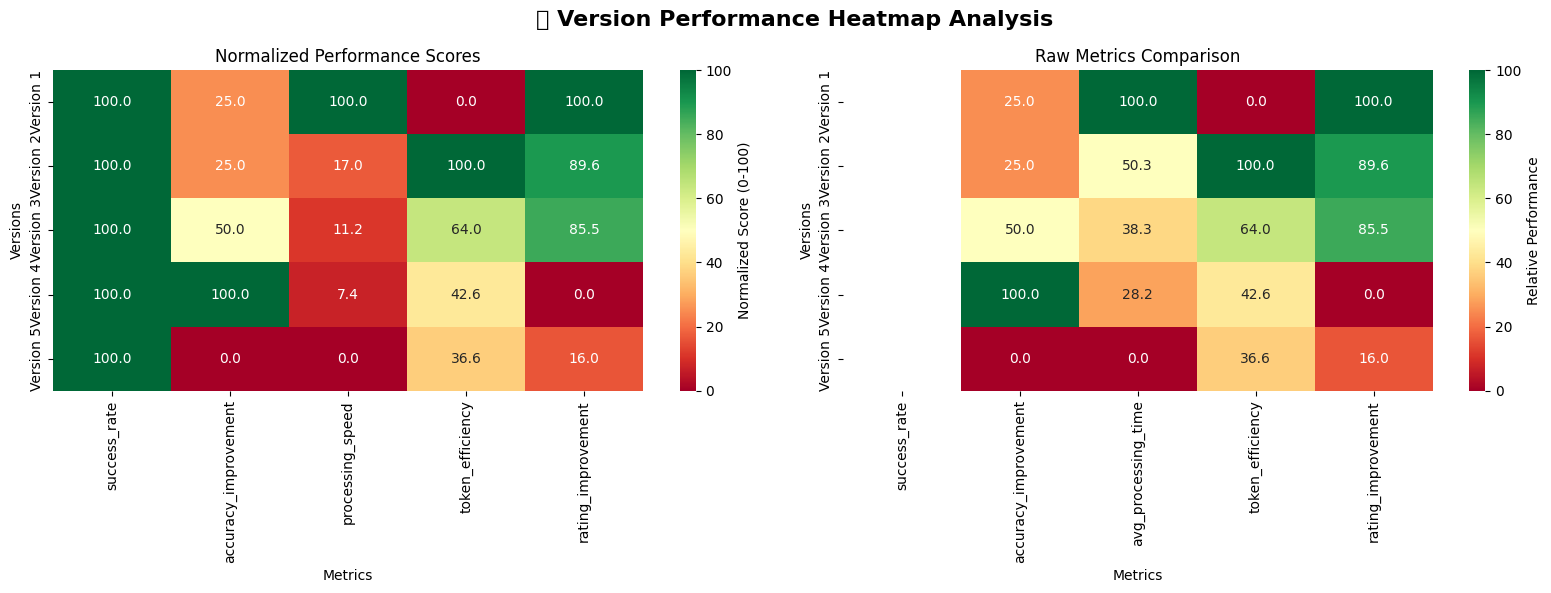


📋 RAW VALUES REFERENCE TABLE:
           success_rate  accuracy_improvement  avg_processing_time  token_efficiency  rating_improvement
Version 1         100.0                 1.429            66464.917             0.080               0.468
Version 2         100.0                 1.429           196097.675             0.119               0.468
Version 3         100.0                 2.857           227156.172             0.105               0.467
Version 4         100.0                 5.714           253619.806             0.097               0.464
Version 5         100.0                 0.000           327053.242             0.094               0.464


In [28]:
# Version Performance Heatmap
def create_performance_heatmap(ranking_results):
    """
    Create a performance heatmap for all versions across all metrics
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('🔥 Version Performance Heatmap Analysis', fontsize=16, fontweight='bold')
    
    # Prepare data for heatmap
    versions = list(ranking_results['normalized_data'].keys())
    metrics = list(ranking_results['normalized_data'][versions[0]].keys())
    
    # Create matrix for normalized scores
    heatmap_data = []
    for version in versions:
        row = [ranking_results['normalized_data'][version][metric] for metric in metrics]
        heatmap_data.append(row)
    
    heatmap_df = pd.DataFrame(heatmap_data, index=versions, columns=metrics)
    
    # Normalized performance heatmap
    sns.heatmap(heatmap_df, annot=True, fmt='.1f', cmap='RdYlGn', 
                ax=axes[0], cbar_kws={'label': 'Normalized Score (0-100)'})
    axes[0].set_title('Normalized Performance Scores')
    axes[0].set_xlabel('Metrics')
    axes[0].set_ylabel('Versions')
    
    # Raw values heatmap
    raw_metrics = ['success_rate', 'accuracy_improvement', 'avg_processing_time', 
                   'token_efficiency', 'rating_improvement']
    raw_data = []
    for version in versions:
        row = [ranking_results['raw_data'][version][metric] for metric in raw_metrics]
        raw_data.append(row)
    
    raw_df = pd.DataFrame(raw_data, index=versions, columns=raw_metrics)
    
    # Normalize raw data for heatmap visualization
    raw_df_normalized = raw_df.copy()
    for col in raw_df_normalized.columns:
        if col == 'avg_processing_time':  # Lower is better for processing time
            raw_df_normalized[col] = 100 - ((raw_df_normalized[col] - raw_df_normalized[col].min()) / 
                                           (raw_df_normalized[col].max() - raw_df_normalized[col].min()) * 100)
        else:  # Higher is better for other metrics
            raw_df_normalized[col] = ((raw_df_normalized[col] - raw_df_normalized[col].min()) / 
                                     (raw_df_normalized[col].max() - raw_df_normalized[col].min()) * 100)
    
    sns.heatmap(raw_df_normalized, annot=True, fmt='.1f', cmap='RdYlGn',
                ax=axes[1], cbar_kws={'label': 'Relative Performance'})
    axes[1].set_title('Raw Metrics Comparison')
    axes[1].set_xlabel('Metrics')
    axes[1].set_ylabel('Versions')
    
    plt.tight_layout()
    plt.show()
    
    # Print raw values table for reference
    print("\n📋 RAW VALUES REFERENCE TABLE:")
    print("=" * 60)
    print(raw_df.round(3).to_string())

create_performance_heatmap(ranking_results)

## STATISTICAL ANALYSIS AND RECOMMENDATIONS

In [29]:
def statistical_analysis_and_recommendations(combined_df, ranking_results):
    """
    Perform statistical analysis and generate actionable recommendations
    """
    print("\n" + "="*70)
    print("📊 STATISTICAL ANALYSIS & RECOMMENDATIONS")
    print("="*70)
    
    versions = combined_df['version'].unique()
    
    # Statistical significance testing
    print("🔬 STATISTICAL SIGNIFICANCE TESTS:")
    print("-" * 50)
    
    # ANOVA tests for continuous variables
    continuous_vars = ['processing_time_ms', 'total_llm_calls', 'token_efficiency', 'rating_improvement']
    
    for var in continuous_vars:
        if var in combined_df.columns:
            groups = []
            group_names = []
            for version in versions:
                version_data = combined_df[combined_df['version'] == version][var].dropna()
                if len(version_data) > 1:  # Need at least 2 data points
                    groups.append(version_data)
                    group_names.append(version)
            
            if len(groups) >= 2:
                try:
                    # Check if there's any variance in the data
                    all_data = np.concatenate(groups)
                    if np.var(all_data) > 1e-10:  # Avoid division by zero
                        f_stat, p_value = stats.f_oneway(*groups)
                        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
                        print(f"  {var}: F={f_stat:.3f}, p={p_value:.4f} {significance}")
                    else:
                        print(f"  {var}: No variance detected (all values approximately equal)")
                except Exception as e:
                    print(f"  {var}: ANOVA failed ({str(e)[:30]}...)")
            else:
                print(f"  {var}: Insufficient data for ANOVA (need ≥2 groups with ≥2 data points each)")
    
    # Effect size analysis (Cohen's d between best and worst versions)
    best_version = ranking_results['final_ranking'][0][0]
    worst_version = ranking_results['final_ranking'][-1][0]
    
    print(f"\n📏 EFFECT SIZE ANALYSIS ({best_version} vs {worst_version}):")
    print("-" * 50)
    
    def cohens_d(group1, group2):
        """Calculate Cohen's d effect size with error handling"""
        try:
            if len(group1) < 2 or len(group2) < 2:
                return np.nan
            
            n1, n2 = len(group1), len(group2)
            s1, s2 = group1.std(), group2.std()
            
            # Handle case where standard deviations are zero
            if s1 == 0 and s2 == 0:
                return 0.0 if group1.mean() == group2.mean() else np.inf
            
            pooled_std = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1+n2-2))
            
            if pooled_std == 0:
                return 0.0 if group1.mean() == group2.mean() else np.inf
            
            return (group1.mean() - group2.mean()) / pooled_std
        except Exception as e:
            return np.nan
    
    for var in continuous_vars:
        if var in combined_df.columns:
            best_data = combined_df[combined_df['version'] == best_version][var].dropna()
            worst_data = combined_df[combined_df['version'] == worst_version][var].dropna()
            
            if len(best_data) > 0 and len(worst_data) > 0:
                effect_size = cohens_d(best_data, worst_data)
                magnitude = ("Large" if abs(effect_size) >= 0.8 else 
                           "Medium" if abs(effect_size) >= 0.5 else "Small")
                print(f"  {var}: Cohen's d = {effect_size:.3f} ({magnitude})")
    
    # Confidence intervals for key metrics
    print(f"\n🎯 95% CONFIDENCE INTERVALS FOR KEY METRICS:")
    print("-" * 50)
    
    for version in versions:
        version_data = combined_df[combined_df['version'] == version]
        print(f"\n{version}:")
        
        # Success rate CI
        n = len(version_data)
        p = version_data['success'].mean()
        se = np.sqrt(p * (1-p) / n)
        ci_lower = p - 1.96 * se
        ci_upper = p + 1.96 * se
        print(f"  Success Rate: {p*100:.1f}% [{ci_lower*100:.1f}%, {ci_upper*100:.1f}%]")
        
        # Processing time CI
        if 'processing_time_ms' in version_data.columns:
            times = version_data['processing_time_ms'].dropna()
            if len(times) > 1:
                mean_time = times.mean()
                se_time = times.std() / np.sqrt(len(times))
                ci_lower_time = mean_time - 1.96 * se_time
                ci_upper_time = mean_time + 1.96 * se_time
                print(f"  Processing Time: {mean_time:.1f}ms [{ci_lower_time:.1f}ms, {ci_upper_time:.1f}ms]")
    
    # Generate recommendations
    print(f"\n🎯 ACTIONABLE RECOMMENDATIONS:")
    print("="*50)
    
    recommendations = []
    
    # Best performer analysis
    best_version = ranking_results['final_ranking'][0][0]
    best_score = ranking_results['final_ranking'][0][1]
    
    recommendations.append(f"🥇 ADOPT BEST PRACTICES: {best_version} achieved the highest overall score ({best_score:.1f}/100)")
    
    # Identify strongest metrics per version
    metric_winners = {}
    for metric in ranking_results['metric_rankings']:
        winner = ranking_results['metric_rankings'][metric][0]
        metric_winners[metric] = winner
    
    print(f"\n🏆 METRIC CHAMPIONS:")
    for metric, (version, score) in metric_winners.items():
        print(f"  • {metric.replace('_', ' ').title()}: {version} ({score:.1f}/100)")
        
        if metric == 'processing_speed':
            recommendations.append(f"⚡ SPEED OPTIMIZATION: Learn from {version}'s processing optimizations")
        elif metric == 'accuracy_improvement':
            recommendations.append(f"🎯 ACCURACY FOCUS: Adopt {version}'s verification strategies")
        elif metric == 'token_efficiency':
            recommendations.append(f"💰 COST OPTIMIZATION: Implement {version}'s token efficiency techniques")
    
    # Identify improvement opportunities
    print(f"\n🔍 IMPROVEMENT OPPORTUNITIES:")
    
    for version in versions:
        version_scores = {metric: ranking_results['normalized_data'][version][metric] 
                         for metric in ranking_results['normalized_data'][version]}
        weakest_metric = min(version_scores, key=version_scores.get)
        weakest_score = version_scores[weakest_metric]
        
        if weakest_score < 50:  # Below average performance
            print(f"  • {version}: Improve {weakest_metric.replace('_', ' ')} (current: {weakest_score:.1f}/100)")
            recommendations.append(f"📈 {version} FOCUS: Prioritize {weakest_metric.replace('_', ' ')} improvements")
    
    # Version-specific insights
    print(f"\n💡 VERSION-SPECIFIC INSIGHTS:")
    
    for version in versions:
        version_data = combined_df[combined_df['version'] == version]
        insights = []
        
        # Success rate insight
        success_rate = version_data['success'].mean() * 100
        if success_rate >= 95:
            insights.append("Very high reliability")
        elif success_rate < 80:
            insights.append("Reliability concerns")
        
        # Processing time insight
        avg_time = version_data['processing_time_ms'].mean()
        if avg_time < 50:
            insights.append("Fast processing")
        elif avg_time > 100:
            insights.append("Slow processing")
        
        # Token efficiency insight
        token_eff = version_data['token_efficiency'].mean()
        if token_eff > 0.3:
            insights.append("High token efficiency")
        elif token_eff < 0.15:
            insights.append("Low token efficiency")
        
        if insights:
            print(f"  • {version}: {', '.join(insights)}")
    
    # Final recommendations
    print(f"\n📋 FINAL RECOMMENDATIONS:")
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")
    
    # Strategic recommendations
    strategic_recs = [
        "🔄 Implement A/B testing framework to continuously evaluate version performance",
        "📊 Set up monitoring dashboards to track key metrics in real-time", 
        "🎯 Focus development efforts on the weakest performing metrics",
        "🔬 Conduct detailed analysis of failure cases to improve reliability",
        "💰 Optimize token usage based on best-performing version's strategies"
    ]
    
    print(f"\n🚀 STRATEGIC RECOMMENDATIONS:")
    for i, rec in enumerate(strategic_recs, 1):
        print(f"{i}. {rec}")

    return {
        'recommendations': recommendations,
        'strategic_recommendations': strategic_recs,
        'metric_winners': metric_winners
    }

# Run statistical analysis and recommendations
analysis_recommendations = statistical_analysis_and_recommendations(combined_df, ranking_results)



📊 STATISTICAL ANALYSIS & RECOMMENDATIONS
🔬 STATISTICAL SIGNIFICANCE TESTS:
--------------------------------------------------
  processing_time_ms: F=15.267, p=0.0000 ***
  total_llm_calls: F=38.218, p=0.0000 ***
  token_efficiency: F=8.279, p=0.0000 ***
  rating_improvement: F=0.004, p=1.0000 ns

📏 EFFECT SIZE ANALYSIS (Version 1 vs Version 5):
--------------------------------------------------
  processing_time_ms: Cohen's d = -1.216 (Large)
  total_llm_calls: Cohen's d = -1.863 (Large)
  token_efficiency: Cohen's d = -0.372 (Small)
  rating_improvement: Cohen's d = 0.013 (Small)

🎯 95% CONFIDENCE INTERVALS FOR KEY METRICS:
--------------------------------------------------

Version 1:
  Success Rate: 100.0% [100.0%, 100.0%]
  Processing Time: 66464.9ms [52980.2ms, 79949.6ms]

Version 2:
  Success Rate: 100.0% [100.0%, 100.0%]
  Processing Time: 196097.7ms [156719.2ms, 235476.1ms]

Version 3:
  Success Rate: 100.0% [100.0%, 100.0%]
  Processing Time: 227156.2ms [180544.5ms, 273767.8

## CORRELATION HEATMAP ANALYSIS (14x14)


🔥 CORRELATION HEATMAP ANALYSIS (14x14)
📊 Available columns: 14/14


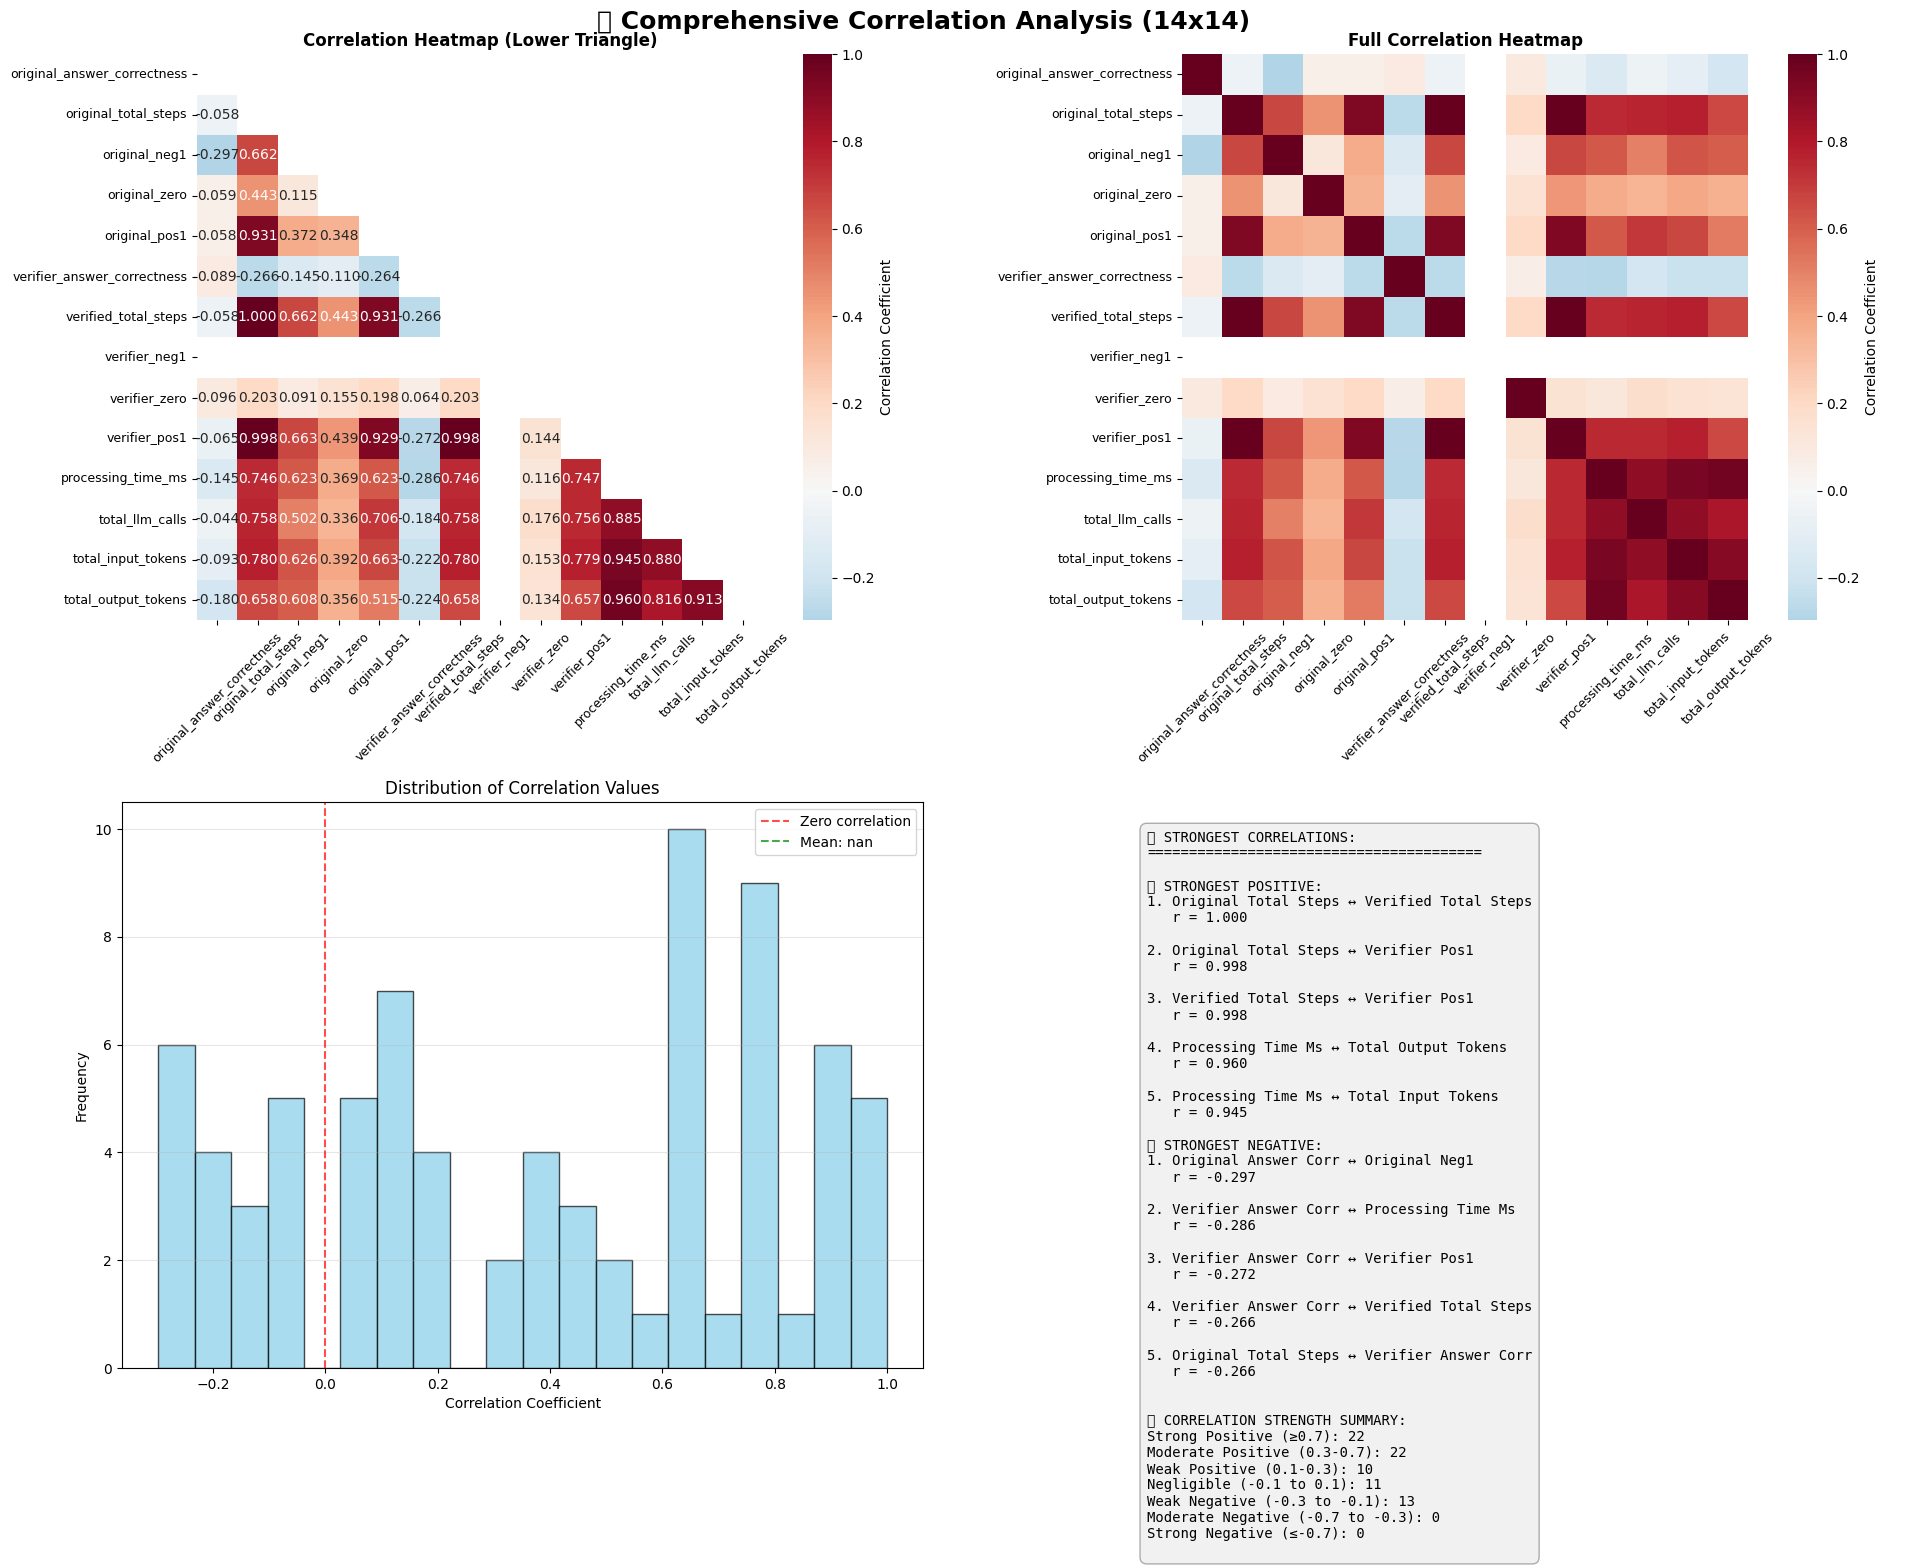


📋 DETAILED CORRELATION ANALYSIS:
📊 Dataset Statistics:
   • Total correlations calculated: 78
   • Mean correlation: 0.375
   • Std correlation: 0.404
   • Max correlation: 1.000
   • Min correlation: -0.297

🔍 VERSION-SPECIFIC CORRELATION INSIGHTS:
   • Version 1: Strongest |r|=1.000, Mean |r|=0.490
   • Version 2: Strongest |r|=1.000, Mean |r|=0.511
   • Version 3: Strongest |r|=1.000, Mean |r|=0.513
   • Version 4: Strongest |r|=1.000, Mean |r|=0.509
   • Version 5: Strongest |r|=1.000, Mean |r|=0.481


In [30]:
def create_correlation_heatmap_analysis(combined_df):
    """
    Create comprehensive 14x14 correlation heatmap analysis
    """
    print("\n" + "="*70)
    print("🔥 CORRELATION HEATMAP ANALYSIS (14x14)")
    print("="*70)
    
    # Define the 14 columns for correlation analysis
    correlation_columns = [
        'original_answer_correctness',
        'original_total_steps', 
        'original_neg1',
        'original_zero',
        'original_pos1',
        'verifier_answer_correctness',
        'verified_total_steps',
        'verifier_neg1', 
        'verifier_zero',
        'verifier_pos1',
        'processing_time_ms',
        'total_llm_calls',
        'total_input_tokens',
        'total_output_tokens'
    ]
    
    # Check which columns exist in the dataset
    available_columns = []
    missing_columns = []
    
    for col in correlation_columns:
        if col in combined_df.columns:
            available_columns.append(col)
        else:
            missing_columns.append(col)
    
    print(f"📊 Available columns: {len(available_columns)}/{len(correlation_columns)}")
    if missing_columns:
        print(f"⚠️  Missing columns: {missing_columns}")
    
    # Prepare data for correlation analysis
    correlation_data = combined_df[available_columns].copy()
    
    # Convert boolean columns to numeric
    bool_columns = ['original_answer_correctness', 'verifier_answer_correctness']
    for col in bool_columns:
        if col in correlation_data.columns:
            correlation_data[col] = correlation_data[col].astype(int)
    
    # Calculate correlation matrix
    correlation_matrix = correlation_data.corr()
    
    # Create the heatmap visualization
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('🔥 Comprehensive Correlation Analysis (14x14)', fontsize=18, fontweight='bold')
    
    # 1. Main correlation heatmap (top left)
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle
    sns.heatmap(correlation_matrix, 
                annot=True, 
                fmt='.3f',
                cmap='RdBu_r',
                center=0,
                square=True,
                mask=mask,
                cbar_kws={'label': 'Correlation Coefficient'},
                ax=axes[0,0])
    axes[0,0].set_title('Correlation Heatmap (Lower Triangle)', fontweight='bold')
    axes[0,0].tick_params(axis='x', rotation=45, labelsize=9)
    axes[0,0].tick_params(axis='y', rotation=0, labelsize=9)
    
    # 2. Full correlation heatmap without mask (top right)
    sns.heatmap(correlation_matrix,
                annot=False,  # No annotations for better visibility
                cmap='RdBu_r',
                center=0,
                square=True,
                cbar_kws={'label': 'Correlation Coefficient'},
                ax=axes[0,1])
    axes[0,1].set_title('Full Correlation Heatmap', fontweight='bold')
    axes[0,1].tick_params(axis='x', rotation=45, labelsize=9)
    axes[0,1].tick_params(axis='y', rotation=0, labelsize=9)
    
    # 3. Correlation strength distribution (bottom left)
    correlation_values = correlation_matrix.values
    correlation_flat = correlation_values[np.triu_indices_from(correlation_values, k=1)]  # Upper triangle excluding diagonal
    
    axes[1,0].hist(correlation_flat, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1,0].axvline(0, color='red', linestyle='--', alpha=0.7, label='Zero correlation')
    axes[1,0].axvline(np.mean(correlation_flat), color='green', linestyle='--', alpha=0.7, 
                     label=f'Mean: {np.mean(correlation_flat):.3f}')
    axes[1,0].set_xlabel('Correlation Coefficient')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Distribution of Correlation Values')
    axes[1,0].legend()
    axes[1,0].grid(axis='y', alpha=0.3)
    
    # 4. Top correlations analysis (bottom right)
    axes[1,1].axis('off')
    
    # Find strongest positive and negative correlations
    correlation_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = correlation_matrix.iloc[i, j]
            if not np.isnan(corr_value):
                correlation_pairs.append((
                    correlation_matrix.columns[i],
                    correlation_matrix.columns[j], 
                    corr_value
                ))
    
    # Sort by absolute correlation value
    correlation_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    
    # Display top correlations
    top_correlations_text = "🔝 STRONGEST CORRELATIONS:\n" + "="*40 + "\n\n"
    
    top_correlations_text += "📈 STRONGEST POSITIVE:\n"
    positive_corrs = [pair for pair in correlation_pairs if pair[2] > 0][:5]
    for i, (col1, col2, corr) in enumerate(positive_corrs, 1):
        col1_short = col1.replace('_', ' ').title()[:20]
        col2_short = col2.replace('_', ' ').title()[:20]
        top_correlations_text += f"{i}. {col1_short} ↔ {col2_short}\n   r = {corr:.3f}\n\n"
    
    top_correlations_text += "📉 STRONGEST NEGATIVE:\n"
    negative_corrs = [pair for pair in correlation_pairs if pair[2] < 0][:5]
    for i, (col1, col2, corr) in enumerate(negative_corrs, 1):
        col1_short = col1.replace('_', ' ').title()[:20]
        col2_short = col2.replace('_', ' ').title()[:20]
        top_correlations_text += f"{i}. {col1_short} ↔ {col2_short}\n   r = {corr:.3f}\n\n"
    
    # Calculate correlation strength categories
    strong_pos = len([pair for pair in correlation_pairs if pair[2] >= 0.7])
    moderate_pos = len([pair for pair in correlation_pairs if 0.3 <= pair[2] < 0.7])
    weak_pos = len([pair for pair in correlation_pairs if 0.1 <= pair[2] < 0.3])
    negligible = len([pair for pair in correlation_pairs if -0.1 < pair[2] < 0.1])
    weak_neg = len([pair for pair in correlation_pairs if -0.3 < pair[2] <= -0.1])
    moderate_neg = len([pair for pair in correlation_pairs if -0.7 < pair[2] <= -0.3])
    strong_neg = len([pair for pair in correlation_pairs if pair[2] <= -0.7])
    
    top_correlations_text += f"\n📊 CORRELATION STRENGTH SUMMARY:\n"
    top_correlations_text += f"Strong Positive (≥0.7): {strong_pos}\n"
    top_correlations_text += f"Moderate Positive (0.3-0.7): {moderate_pos}\n"
    top_correlations_text += f"Weak Positive (0.1-0.3): {weak_pos}\n"
    top_correlations_text += f"Negligible (-0.1 to 0.1): {negligible}\n"
    top_correlations_text += f"Weak Negative (-0.3 to -0.1): {weak_neg}\n"
    top_correlations_text += f"Moderate Negative (-0.7 to -0.3): {moderate_neg}\n"
    top_correlations_text += f"Strong Negative (≤-0.7): {strong_neg}\n"
    
    axes[1,1].text(0.05, 0.95, top_correlations_text, transform=axes[1,1].transAxes, 
                   fontsize=10, verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.3))
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed correlation analysis
    print(f"\n📋 DETAILED CORRELATION ANALYSIS:")
    print("="*50)
    
    print(f"📊 Dataset Statistics:")
    print(f"   • Total correlations calculated: {len(correlation_pairs)}")
    print(f"   • Mean correlation: {np.mean([pair[2] for pair in correlation_pairs]):.3f}")
    print(f"   • Std correlation: {np.std([pair[2] for pair in correlation_pairs]):.3f}")
    print(f"   • Max correlation: {max([pair[2] for pair in correlation_pairs]):.3f}")
    print(f"   • Min correlation: {min([pair[2] for pair in correlation_pairs]):.3f}")
    
    # Version-specific correlation analysis
    print(f"\n🔍 VERSION-SPECIFIC CORRELATION INSIGHTS:")
    for version in combined_df['version'].unique():
        version_data = combined_df[combined_df['version'] == version]
        version_corr_data = version_data[available_columns].copy()
        
        # Convert boolean columns to numeric for this version
        for col in bool_columns:
            if col in version_corr_data.columns:
                version_corr_data[col] = version_corr_data[col].astype(int)
        
        if len(version_corr_data) > 2:  # Need sufficient data for correlation
            version_corr_matrix = version_corr_data.corr()
            
            # Find strongest correlation for this version
            version_pairs = []
            for i in range(len(version_corr_matrix.columns)):
                for j in range(i+1, len(version_corr_matrix.columns)):
                    corr_value = version_corr_matrix.iloc[i, j]
                    if not np.isnan(corr_value):
                        version_pairs.append((
                            version_corr_matrix.columns[i],
                            version_corr_matrix.columns[j], 
                            corr_value
                        ))
            
            if version_pairs:
                strongest_corr = max(version_pairs, key=lambda x: abs(x[2]))
                mean_corr = np.mean([abs(pair[2]) for pair in version_pairs])
                print(f"   • {version}: Strongest |r|={abs(strongest_corr[2]):.3f}, Mean |r|={mean_corr:.3f}")
    
    return {
        'correlation_matrix': correlation_matrix,
        'correlation_pairs': correlation_pairs,
        'available_columns': available_columns,
        'missing_columns': missing_columns,
        'correlation_stats': {
            'mean': np.mean([pair[2] for pair in correlation_pairs]),
            'std': np.std([pair[2] for pair in correlation_pairs]),
            'max': max([pair[2] for pair in correlation_pairs]) if correlation_pairs else 0,
            'min': min([pair[2] for pair in correlation_pairs]) if correlation_pairs else 0
        }
    }

# Run correlation heatmap analysis
correlation_results = create_correlation_heatmap_analysis(combined_df)


## STEPS vs LLM CALLS RELATIONSHIP ANALYSIS


📈 STEPS vs LLM CALLS RELATIONSHIP ANALYSIS


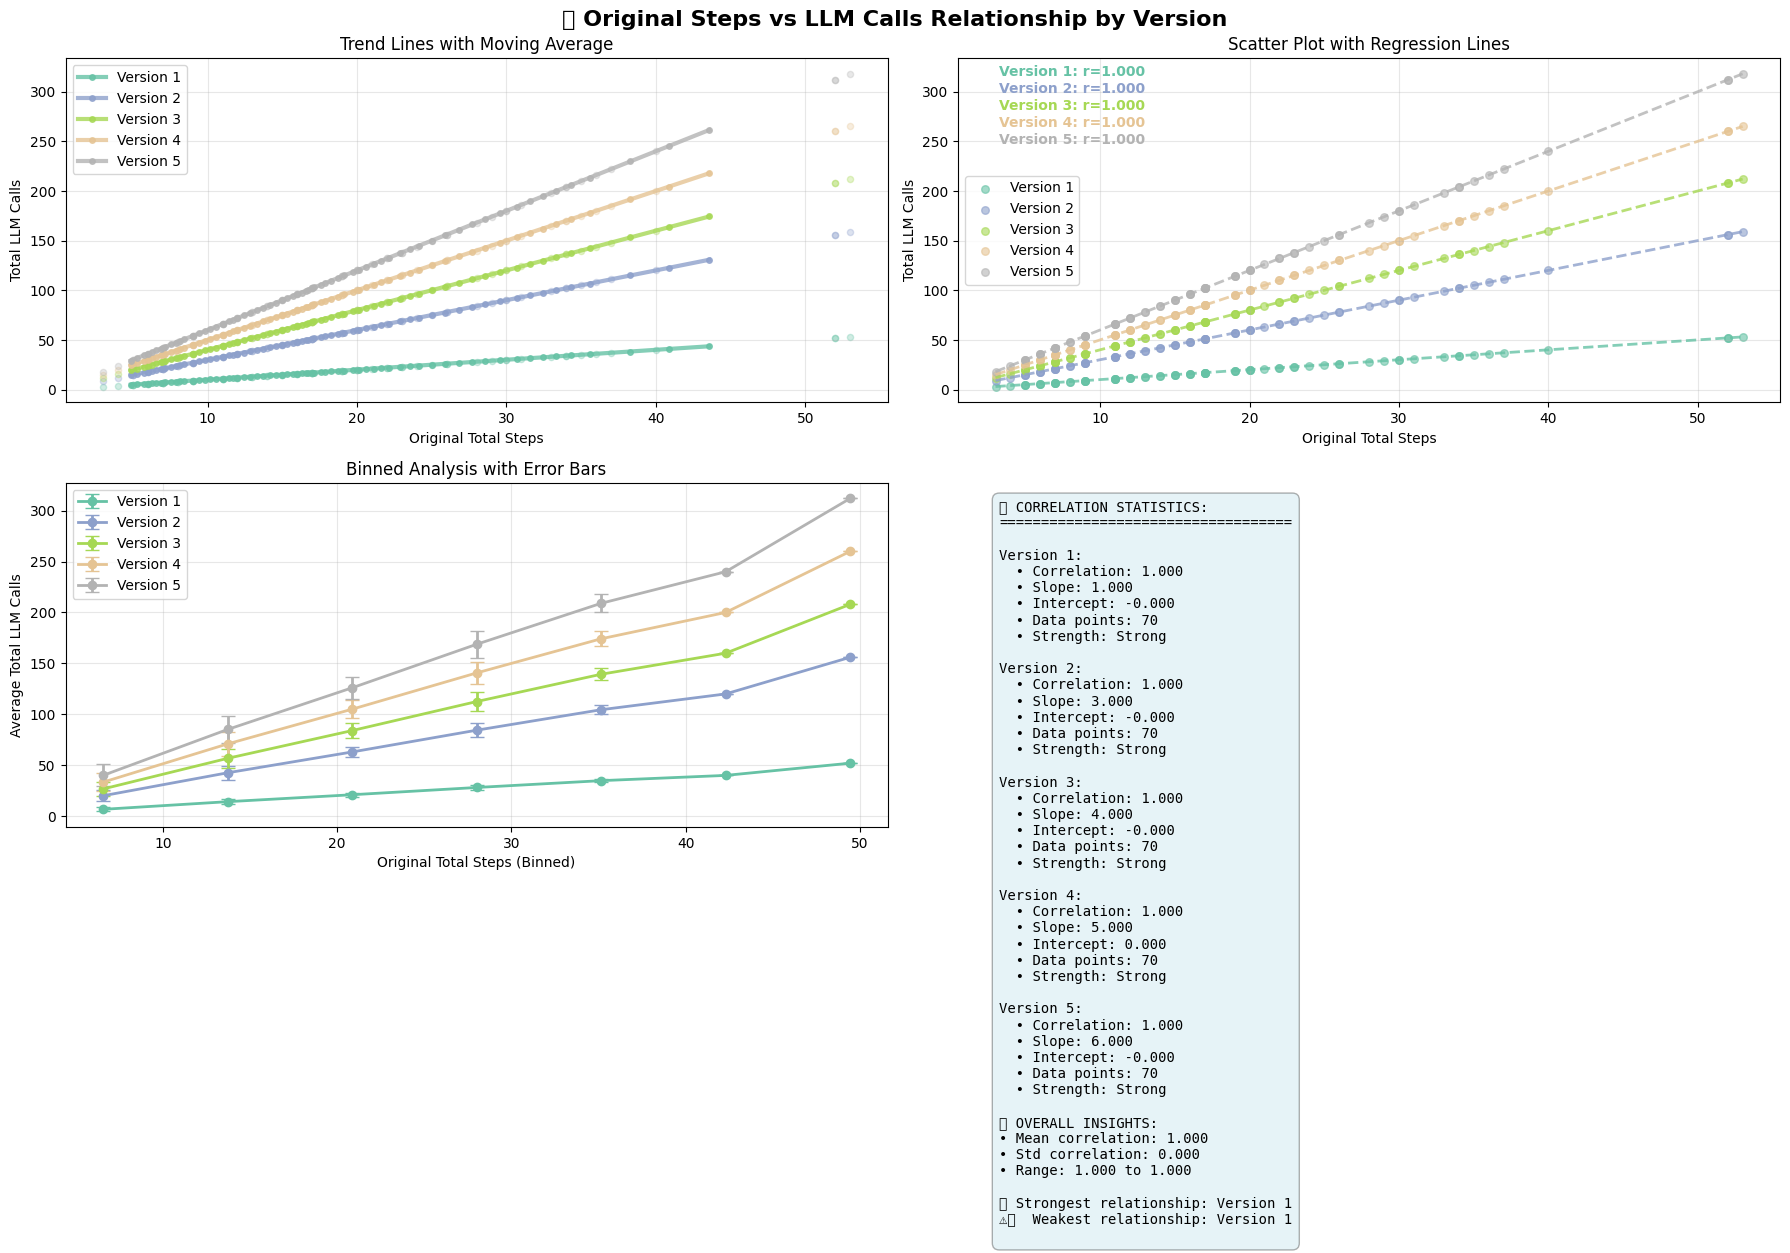


💡 KEY INSIGHTS:
🚀 STRONG RELATIONSHIP: Steps strongly predict LLM calls across versions
   • Average correlation across versions: 1.000
   • Most consistent version: Version 1

✅ PRACTICAL IMPLICATIONS:
   • LLM usage is somewhat predictable from problem complexity
   • Resource planning can be based on step count estimation
   • Cost optimization opportunities exist


In [31]:
def create_steps_vs_llm_calls_analysis(combined_df):
    """
    Create line graphics showing relationship between original_total_steps and total_llm_calls by version
    """
    print("\n" + "="*70)
    print("📈 STEPS vs LLM CALLS RELATIONSHIP ANALYSIS")
    print("="*70)
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('📈 Original Steps vs LLM Calls Relationship by Version', fontsize=16, fontweight='bold')
    
    versions = combined_df['version'].unique()
    colors = plt.cm.Set2(np.linspace(0, 1, len(versions)))
    
    # 1. Line plot with trend lines (top left)
    ax1 = axes[0, 0]
    
    for i, version in enumerate(versions):
        version_data = combined_df[combined_df['version'] == version]
        valid_data = version_data.dropna(subset=['original_total_steps', 'total_llm_calls'])
        
        if len(valid_data) > 1:
            # Sort by original_total_steps for smooth line
            valid_data_sorted = valid_data.sort_values('original_total_steps')
            
            # Calculate moving average for smoother line
            window_size = max(3, len(valid_data_sorted) // 10)
            if len(valid_data_sorted) >= window_size:
                steps_smooth = valid_data_sorted['original_total_steps'].rolling(window=window_size, center=True).mean()
                llm_calls_smooth = valid_data_sorted['total_llm_calls'].rolling(window=window_size, center=True).mean()
                
                ax1.plot(steps_smooth, llm_calls_smooth, 
                        color=colors[i], linewidth=3, alpha=0.8, label=version, marker='o', markersize=4)
            
            # Add scatter points
            ax1.scatter(valid_data['original_total_steps'], valid_data['total_llm_calls'], 
                       color=colors[i], alpha=0.3, s=20)
    
    ax1.set_xlabel('Original Total Steps')
    ax1.set_ylabel('Total LLM Calls')
    ax1.set_title('Trend Lines with Moving Average')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Scatter plot with regression lines (top right)
    ax2 = axes[0, 1]
    
    for i, version in enumerate(versions):
        version_data = combined_df[combined_df['version'] == version]
        valid_data = version_data.dropna(subset=['original_total_steps', 'total_llm_calls'])
        
        if len(valid_data) > 1:
            x = valid_data['original_total_steps']
            y = valid_data['total_llm_calls']
            
            # Scatter plot
            ax2.scatter(x, y, color=colors[i], alpha=0.6, label=version, s=30)
            
            # Add regression line
            if len(valid_data) > 2:
                z = np.polyfit(x, y, 1)
                p = np.poly1d(z)
                x_line = np.linspace(x.min(), x.max(), 100)
                ax2.plot(x_line, p(x_line), color=colors[i], linestyle='--', linewidth=2, alpha=0.8)
                
                # Calculate correlation for this version
                correlation = x.corr(y)
                ax2.text(0.05, 0.95 - i*0.05, f'{version}: r={correlation:.3f}', 
                        transform=ax2.transAxes, color=colors[i], fontweight='bold')
    
    ax2.set_xlabel('Original Total Steps')
    ax2.set_ylabel('Total LLM Calls')
    ax2.set_title('Scatter Plot with Regression Lines')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Binned analysis (bottom left)
    ax3 = axes[1, 0]
    
    # Create bins for original_total_steps
    all_steps = combined_df['original_total_steps'].dropna()
    if len(all_steps) > 0:
        bins = np.linspace(all_steps.min(), all_steps.max(), 8)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        for i, version in enumerate(versions):
            version_data = combined_df[combined_df['version'] == version]
            valid_data = version_data.dropna(subset=['original_total_steps', 'total_llm_calls'])
            
            if len(valid_data) > 0:
                # Bin the data
                digitized = np.digitize(valid_data['original_total_steps'], bins)
                bin_means = []
                bin_stds = []
                
                for bin_idx in range(1, len(bins)):
                    mask = digitized == bin_idx
                    if mask.sum() > 0:
                        bin_mean = valid_data[mask]['total_llm_calls'].mean()
                        bin_std = valid_data[mask]['total_llm_calls'].std()
                        bin_means.append(bin_mean)
                        bin_stds.append(bin_std if not np.isnan(bin_std) else 0)
                    else:
                        bin_means.append(np.nan)
                        bin_stds.append(np.nan)
                
                # Plot line with error bars
                valid_indices = ~np.isnan(bin_means)
                if valid_indices.sum() > 0:
                    ax3.errorbar(bin_centers[valid_indices], 
                               np.array(bin_means)[valid_indices],
                               yerr=np.array(bin_stds)[valid_indices],
                               color=colors[i], linewidth=2, marker='o', 
                               markersize=6, label=version, capsize=5)
    
    ax3.set_xlabel('Original Total Steps (Binned)')
    ax3.set_ylabel('Average Total LLM Calls')
    ax3.set_title('Binned Analysis with Error Bars')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Statistical summary (bottom right)
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Calculate correlations and statistics for each version
    stats_text = "📊 CORRELATION STATISTICS:\n" + "="*35 + "\n\n"
    
    overall_correlations = []
    
    for version in versions:
        version_data = combined_df[combined_df['version'] == version]
        valid_data = version_data.dropna(subset=['original_total_steps', 'total_llm_calls'])
        
        if len(valid_data) > 1:
            correlation = valid_data['original_total_steps'].corr(valid_data['total_llm_calls'])
            overall_correlations.append(correlation)
            
            # Calculate additional statistics
            slope, intercept = np.polyfit(valid_data['original_total_steps'], valid_data['total_llm_calls'], 1)
            
            stats_text += f"{version}:\n"
            stats_text += f"  • Correlation: {correlation:.3f}\n"
            stats_text += f"  • Slope: {slope:.3f}\n"
            stats_text += f"  • Intercept: {intercept:.3f}\n"
            stats_text += f"  • Data points: {len(valid_data)}\n"
            
            # Interpret correlation strength
            if abs(correlation) >= 0.7:
                strength = "Strong"
            elif abs(correlation) >= 0.5:
                strength = "Moderate"
            elif abs(correlation) >= 0.3:
                strength = "Weak"
            else:
                strength = "Very Weak"
            stats_text += f"  • Strength: {strength}\n\n"
    
    # Overall statistics
    if overall_correlations:
        stats_text += f"🎯 OVERALL INSIGHTS:\n"
        stats_text += f"• Mean correlation: {np.mean(overall_correlations):.3f}\n"
        stats_text += f"• Std correlation: {np.std(overall_correlations):.3f}\n"
        stats_text += f"• Range: {np.min(overall_correlations):.3f} to {np.max(overall_correlations):.3f}\n\n"
        
        # Best and worst correlations
        best_version_idx = np.argmax([abs(c) for c in overall_correlations])
        worst_version_idx = np.argmin([abs(c) for c in overall_correlations])
        
        stats_text += f"🏆 Strongest relationship: {versions[best_version_idx]}\n"
        stats_text += f"⚠️  Weakest relationship: {versions[worst_version_idx]}\n"
    
    ax4.text(0.05, 0.95, stats_text, transform=ax4.transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.3))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary insights
    print(f"\n💡 KEY INSIGHTS:")
    print("="*30)
    
    if overall_correlations:
        mean_correlation = np.mean(overall_correlations)
        
        if mean_correlation >= 0.7:
            print("🚀 STRONG RELATIONSHIP: Steps strongly predict LLM calls across versions")
        elif mean_correlation >= 0.5:
            print("📈 MODERATE RELATIONSHIP: Steps moderately predict LLM calls")
        elif mean_correlation >= 0.3:
            print("📊 WEAK RELATIONSHIP: Some relationship between steps and LLM calls")
        else:
            print("❓ MINIMAL RELATIONSHIP: Steps don't strongly predict LLM calls")
        
        print(f"   • Average correlation across versions: {mean_correlation:.3f}")
        print(f"   • Most consistent version: {versions[np.argmax([abs(c) for c in overall_correlations])]}")
        
        # Practical implications
        if mean_correlation >= 0.5:
            print("\n✅ PRACTICAL IMPLICATIONS:")
            print("   • LLM usage is somewhat predictable from problem complexity")
            print("   • Resource planning can be based on step count estimation")
            print("   • Cost optimization opportunities exist")
        else:
            print("\n⚠️  PRACTICAL IMPLICATIONS:")
            print("   • LLM usage is less predictable from step count alone")
            print("   • Other factors likely influence resource consumption")
            print("   • Need to investigate additional complexity metrics")
    
    return {
        'version_correlations': dict(zip(versions, overall_correlations)) if overall_correlations else {},
        'mean_correlation': np.mean(overall_correlations) if overall_correlations else 0,
        'correlation_range': (np.min(overall_correlations), np.max(overall_correlations)) if overall_correlations else (0, 0)
    }

# Run steps vs LLM calls analysis
steps_llm_results = create_steps_vs_llm_calls_analysis(combined_df)

## STUART-MAXWELL TEST ANALYSIS


🧪 STUART-MAXWELL TEST ANALYSIS
📊 Available transition columns: 9/9


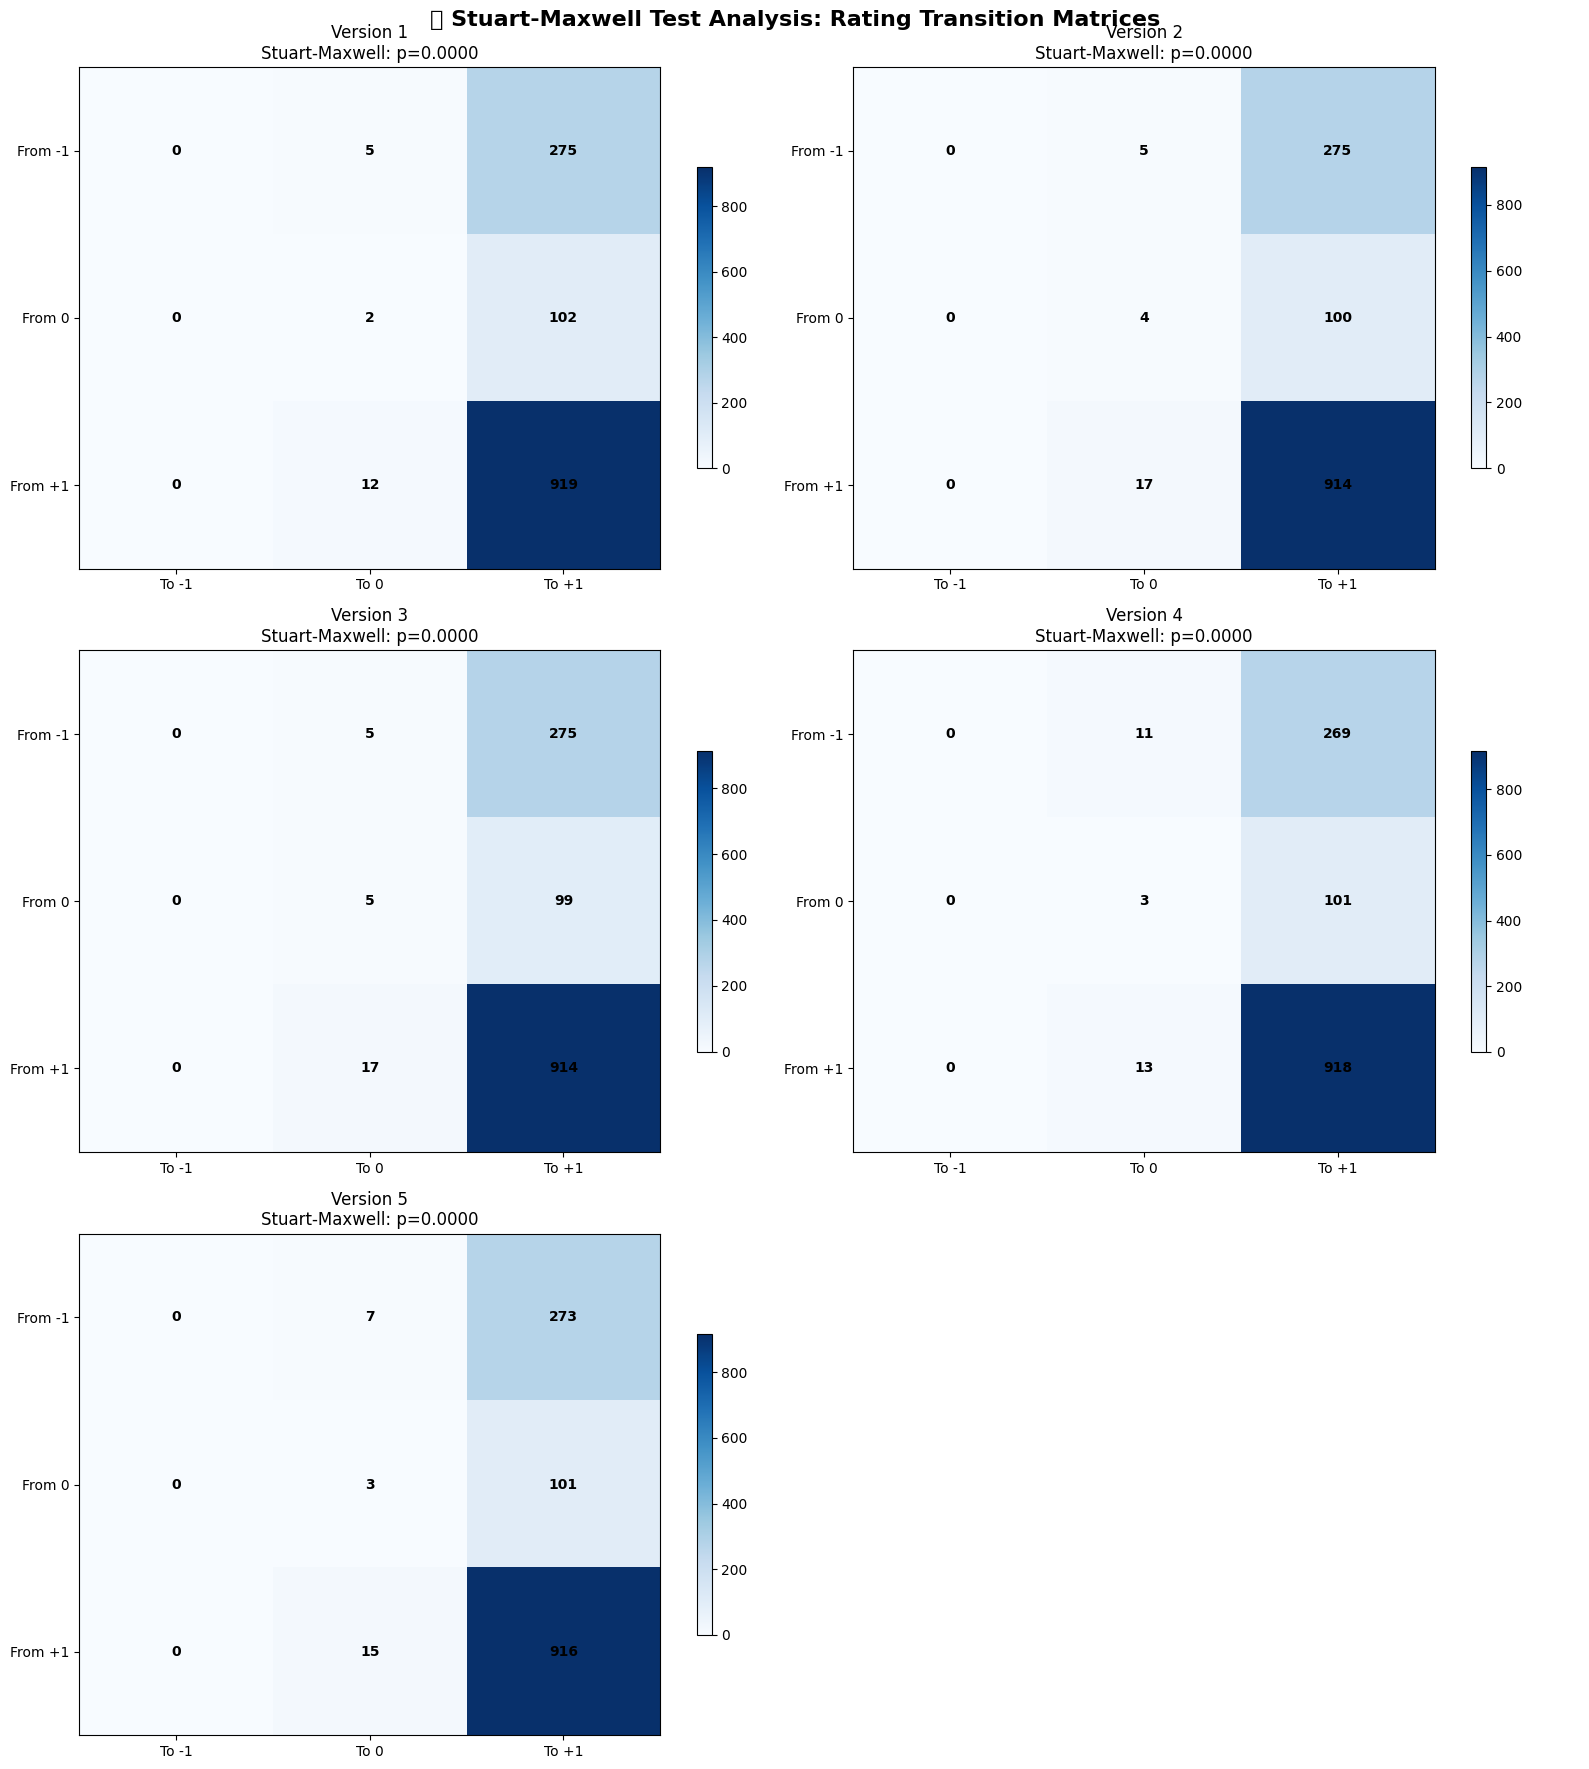


📋 STUART-MAXWELL TEST RESULTS:

Version 1:
  • Sample Size: 1315
  • Test Statistic: 601974929.7192
  • P-value: 0.0000
  • Marginal Homogeneity: Rejected
  • Status: Success
  • Original Ratings: [-1: 280, 0: 104, +1: 931]
  • Verified Ratings: [-1: 0, 0: 19, +1: 1296]

Version 2:
  • Sample Size: 1315
  • Test Statistic: 581899030.0864
  • P-value: 0.0000
  • Marginal Homogeneity: Rejected
  • Status: Success
  • Original Ratings: [-1: 280, 0: 104, +1: 931]
  • Verified Ratings: [-1: 0, 0: 26, +1: 1289]

Version 3:
  • Sample Size: 1315
  • Test Statistic: 580347421.5625
  • P-value: 0.0000
  • Marginal Homogeneity: Rejected
  • Status: Success
  • Original Ratings: [-1: 280, 0: 104, +1: 931]
  • Verified Ratings: [-1: 0, 0: 27, +1: 1288]

Version 4:
  • Sample Size: 1315
  • Test Statistic: 591683592.1041
  • P-value: 0.0000
  • Marginal Homogeneity: Rejected
  • Status: Success
  • Original Ratings: [-1: 280, 0: 104, +1: 931]
  • Verified Ratings: [-1: 0, 0: 27, +1: 1288]

Version

In [32]:
def create_stuart_maxwell_analysis(combined_df):
    """
    Perform Stuart-Maxwell test analysis on rating transition matrices for each version
    """
    print("\n" + "="*70)
    print("🧪 STUART-MAXWELL TEST ANALYSIS")
    print("="*70)
    
    # Define transition columns
    transition_columns = [
        'neg1_to_neg1', 'neg1_to_zero', 'neg1_to_pos1',
        'zero_to_neg1', 'zero_to_zero', 'zero_to_pos1', 
        'pos1_to_neg1', 'pos1_to_zero', 'pos1_to_pos1'
    ]
    
    # Check which transition columns exist
    available_transition_cols = [col for col in transition_columns if col in combined_df.columns]
    missing_transition_cols = [col for col in transition_columns if col not in combined_df.columns]
    
    print(f"📊 Available transition columns: {len(available_transition_cols)}/{len(transition_columns)}")
    if missing_transition_cols:
        print(f"⚠️  Missing columns: {missing_transition_cols}")
    
    if len(available_transition_cols) < 9:
        print(f"❌ Cannot perform complete Stuart-Maxwell analysis - need all 9 transition columns")
        return None
    
    versions = combined_df['version'].unique()
    stuart_maxwell_results = {}
    
    # Create visualization
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle('🧪 Stuart-Maxwell Test Analysis: Rating Transition Matrices', fontsize=16, fontweight='bold')
    
    # Stuart-Maxwell test function
    def stuart_maxwell_test(transition_matrix):
        """
        Perform Stuart-Maxwell test for marginal homogeneity
        """
        try:
            from scipy.stats import chi2
            
            # Reshape 3x3 matrix to vectors
            matrix = np.array(transition_matrix).reshape(3, 3)
            
            # Calculate marginal totals
            row_marginals = matrix.sum(axis=1)  # Original ratings
            col_marginals = matrix.sum(axis=0)  # Verified ratings
            
            # Calculate differences
            d = row_marginals - col_marginals
            
            # Calculate variance-covariance matrix
            n = matrix.sum()
            if n == 0:
                return np.nan, np.nan, "No data"
            
            # Simplified Stuart-Maxwell statistic calculation
            # For 3x3 table, we use the first k-1=2 differences
            d_reduced = d[:-1]  # Remove last element (redundant)
            
            # Calculate covariance matrix elements
            V = np.zeros((2, 2))
            
            # Diagonal elements
            V[0, 0] = (row_marginals[0] + col_marginals[0] - 2*matrix[0, 0]) / n
            V[1, 1] = (row_marginals[1] + col_marginals[1] - 2*matrix[1, 1]) / n
            
            # Off-diagonal elements  
            V[0, 1] = V[1, 0] = -(matrix[0, 1] + matrix[1, 0]) / n
            
            # Check if V is invertible
            det_V = np.linalg.det(V)
            if abs(det_V) < 1e-10:
                return np.nan, np.nan, "Singular covariance matrix"
            
            # Calculate test statistic
            V_inv = np.linalg.inv(V)
            test_statistic = n * d_reduced.T @ V_inv @ d_reduced
            
            # Degrees of freedom (k-1 = 2 for 3x3 table)
            df = 2
            
            # Calculate p-value
            p_value = 1 - chi2.cdf(test_statistic, df)
            
            return test_statistic, p_value, "Success"
            
        except Exception as e:
            return np.nan, np.nan, f"Error: {str(e)}"
    
    # Analyze each version
    for idx, version in enumerate(versions):
        version_data = combined_df[combined_df['version'] == version]
        
        # Sum transition counts for this version
        transition_counts = version_data[available_transition_cols].sum()
        
        # Reshape to 3x3 matrix
        transition_matrix = transition_counts.values.reshape(3, 3)
        
        # Perform Stuart-Maxwell test
        test_stat, p_value, status = stuart_maxwell_test(transition_matrix)
        
        # Store results
        stuart_maxwell_results[version] = {
            'transition_matrix': transition_matrix,
            'test_statistic': test_stat,
            'p_value': p_value,
            'status': status,
            'sample_size': transition_matrix.sum(),
            'marginal_homogeneity': 'Rejected' if (not np.isnan(p_value) and p_value < 0.05) else 'Not Rejected'
        }
        
        # Create subplot for this version's transition matrix
        row = idx // 2
        col = idx % 2
        
        if row < 3:  # Only plot if we have space
            ax = axes[row, col]
            
            # Create heatmap
            im = ax.imshow(transition_matrix, cmap='Blues', aspect='auto')
            
            # Add text annotations
            for i in range(3):
                for j in range(3):
                    text = ax.text(j, i, int(transition_matrix[i, j]),
                                 ha="center", va="center", color="black", fontweight='bold')
            
            ax.set_xticks([0, 1, 2])
            ax.set_yticks([0, 1, 2])
            ax.set_xticklabels(['To -1', 'To 0', 'To +1'])
            ax.set_yticklabels(['From -1', 'From 0', 'From +1'])
            ax.set_title(f'{version}\nStuart-Maxwell: p={p_value:.4f}' if not np.isnan(p_value) else f'{version}\nTest Failed')
            
            # Add colorbar
            plt.colorbar(im, ax=ax, shrink=0.6)
    
    # Hide unused subplots
    for idx in range(len(versions), 6):
        row = idx // 2
        col = idx % 2
        if row < 3:
            axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print(f"\n📋 STUART-MAXWELL TEST RESULTS:")
    print("="*50)
    
    for version, results in stuart_maxwell_results.items():
        print(f"\n{version}:")
        print(f"  • Sample Size: {results['sample_size']}")
        print(f"  • Test Statistic: {results['test_statistic']:.4f}" if not np.isnan(results['test_statistic']) else "  • Test Statistic: Failed")
        print(f"  • P-value: {results['p_value']:.4f}" if not np.isnan(results['p_value']) else "  • P-value: N/A")
        print(f"  • Marginal Homogeneity: {results['marginal_homogeneity']}")
        print(f"  • Status: {results['status']}")
        
        # Calculate marginal totals for interpretation
        matrix = results['transition_matrix']
        row_marginals = matrix.sum(axis=1)
        col_marginals = matrix.sum(axis=0)
        
        print(f"  • Original Ratings: [-1: {row_marginals[0]}, 0: {row_marginals[1]}, +1: {row_marginals[2]}]")
        print(f"  • Verified Ratings: [-1: {col_marginals[0]}, 0: {col_marginals[1]}, +1: {col_marginals[2]}]")
    
    # Cross-version comparison analysis
    print(f"\n🔍 CROSS-VERSION COMPARISON:")
    print("="*40)
    
    # Compare test statistics
    valid_results = {v: r for v, r in stuart_maxwell_results.items() 
                    if not np.isnan(r['test_statistic'])}
    
    if len(valid_results) >= 2:
        # Find version with strongest evidence against marginal homogeneity
        max_test_stat = max(valid_results.values(), key=lambda x: x['test_statistic'])
        min_test_stat = min(valid_results.values(), key=lambda x: x['test_statistic'])
        
        max_version = [v for v, r in valid_results.items() if r['test_statistic'] == max_test_stat['test_statistic']][0]
        min_version = [v for v, r in valid_results.items() if r['test_statistic'] == min_test_stat['test_statistic']][0]
        
        print(f"🔥 Most asymmetric transitions: {max_version} (χ²={max_test_stat['test_statistic']:.3f})")
        print(f"✅ Most symmetric transitions: {min_version} (χ²={min_test_stat['test_statistic']:.3f})")
        
        # Count significant results
        significant_versions = [v for v, r in valid_results.items() 
                              if not np.isnan(r['p_value']) and r['p_value'] < 0.05]
        
        print(f"\n📊 SUMMARY STATISTICS:")
        print(f"  • Versions with significant asymmetry: {len(significant_versions)}/{len(valid_results)}")
        if significant_versions:
            print(f"  • Asymmetric versions: {', '.join(significant_versions)}")
        
        # Calculate improvement/degradation patterns
        print(f"\n📈 RATING CHANGE PATTERNS:")
        for version, results in stuart_maxwell_results.items():
            matrix = results['transition_matrix']
            total_transitions = matrix.sum()
            
            if total_transitions > 0:
                # Calculate improvement (moving to higher rating)
                improvements = matrix[0, 1] + matrix[0, 2] + matrix[1, 2]  # -1→0, -1→+1, 0→+1
                degradations = matrix[1, 0] + matrix[2, 0] + matrix[2, 1]  # 0→-1, +1→-1, +1→0
                unchanged = matrix[0, 0] + matrix[1, 1] + matrix[2, 2]     # -1→-1, 0→0, +1→+1
                
                improvement_rate = (improvements / total_transitions) * 100
                degradation_rate = (degradations / total_transitions) * 100
                stability_rate = (unchanged / total_transitions) * 100
                
                print(f"  {version}:")
                print(f"    • Improvements: {improvement_rate:.1f}% ({improvements}/{total_transitions})")
                print(f"    • Degradations: {degradation_rate:.1f}% ({degradations}/{total_transitions})")
                print(f"    • Stable: {stability_rate:.1f}% ({unchanged}/{total_transitions})")
    
    # Net change analysis
    print(f"\n⚖️  NET RATING CHANGES:")
    print("-"*30)
    
    net_changes = {}
    for version, results in stuart_maxwell_results.items():
        matrix = results['transition_matrix']
        
        # Calculate net change for each rating category
        neg1_net = (matrix[:, 0].sum() - matrix[0, :].sum())  # Net flow into -1
        zero_net = (matrix[:, 1].sum() - matrix[1, :].sum())  # Net flow into 0  
        pos1_net = (matrix[:, 2].sum() - matrix[2, :].sum())  # Net flow into +1
        
        net_changes[version] = {
            'neg1_net': neg1_net,
            'zero_net': zero_net, 
            'pos1_net': pos1_net
        }
        
        print(f"{version}:")
        print(f"  • Net change to -1: {neg1_net:+d}")
        print(f"  • Net change to  0: {zero_net:+d}")
        print(f"  • Net change to +1: {pos1_net:+d}")
    
    # Overall insights
    print(f"\n💡 KEY INSIGHTS:")
    print("="*25)
    
    if valid_results:
        avg_test_stat = np.mean([r['test_statistic'] for r in valid_results.values()])
        significant_count = len([v for v, r in valid_results.items() 
                               if not np.isnan(r['p_value']) and r['p_value'] < 0.05])
        
        if significant_count > len(valid_results) / 2:
            print("🔄 MAJOR FINDING: Most versions show significant rating asymmetries")
            print("   → Verification process systematically changes rating distributions")
        elif significant_count > 0:
            print("📊 MIXED FINDINGS: Some versions show rating asymmetries")
            print("   → Version-specific effects on rating patterns")
        else:
            print("✅ BALANCED FINDINGS: No strong evidence of systematic rating bias")
            print("   → Verification maintains rating distributions well")
        
        # Best performing version
        best_balance = min(valid_results.items(), key=lambda x: x[1]['test_statistic'])
        print(f"\n🏆 Most balanced rating transitions: {best_balance[0]}")
        print(f"   → Lowest asymmetry score: {best_balance[1]['test_statistic']:.3f}")
    
    return stuart_maxwell_results, net_changes

# Run Stuart-Maxwell analysis
stuart_maxwell_results, net_changes = create_stuart_maxwell_analysis(combined_df)